[1.       0.5      0.25     0.125    0.0625   0.03125  0.015625]
polynomal order of High order space: 2
h= 1.0 

[1.30343261]


h= 0.5 

[1.31571612]


h= 0.25 

[1.67985038]


h= 0.125 

[1.90615181]


h= 0.0625 

[1.97012719]


h= 0.03125 

[1.98650762]


h= 0.015625 

[1.99062542]


polynomal order of High order space: 3
h= 1.0 

[1.47509544]


h= 0.5 

[1.499724]


h= 0.25 

[1.78492294]


h= 0.125 

[1.96123074]


h= 0.0625 

[2.01071565]


h= 0.03125 

[2.02335235]


h= 0.015625 

[2.02652675]


[[0.76720499 0.76004237 0.59529111 0.52461719 0.50758144 0.50339601
  0.50235468]
 [0.67792224 0.66678936 0.56024827 0.50988391 0.49733536 0.49422929
  0.49345512]]


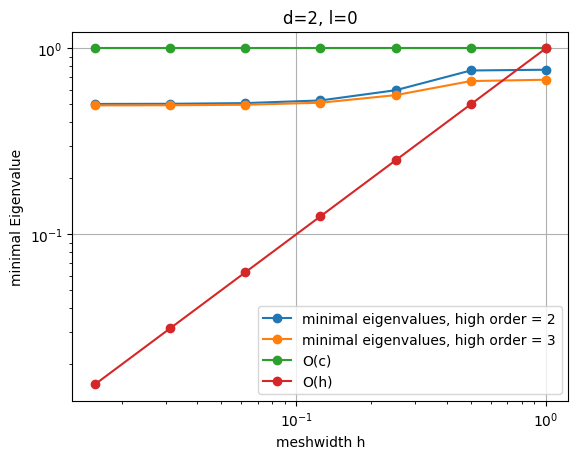

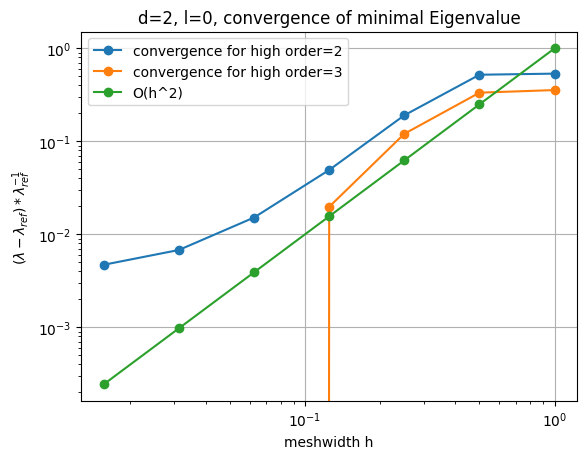

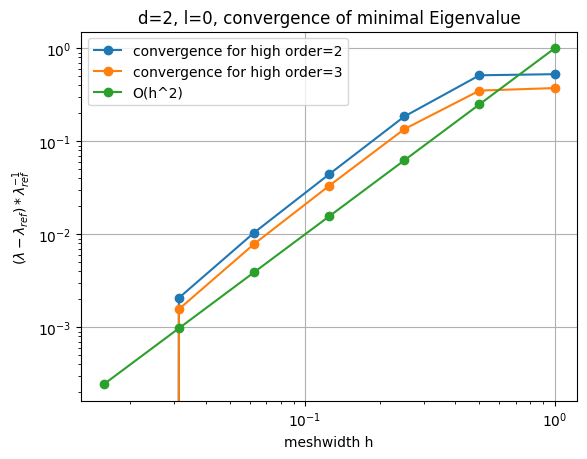

In [8]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

#l is number of meshwidths, the l'th meshwidth is 1/(2^(l-1))
l = 7
meshwidths = np.ones(l)
for h in range(l-1):
    meshwidths[h+1] = meshwidths[h]/2

print(meshwidths)
#polynomal order of the low order space
low_order_value = 1
#polynomal order of high order space in first iteraation
lowest_high_Order = low_order_value + 1
#amount of orders for the high-Order space
orders = 2 
#array storing the minimal Eigenvalue for a given order and meshwidth
minEV = np.zeros((orders,l))

for i in range(lowest_high_Order, lowest_high_Order+orders):
    #reset mesh for new Order
    netgen_mesh =unit_square.GenerateMesh(maxh=1)
    mesh=Mesh(netgen_mesh)

    print("polynomal order of High order space:", i)
    for k in range(l):
        print("h=",meshwidths[k], "\n")
        #Draw(mesh)

        #set function space, for l=0 its normal lagrangian finite elements
        #need to compress to remove DOFs of unrefined mesh after refinement
        H_h = Compress(H1(mesh, order = low_order_value, complex=True)) # main function space
        H_H = Compress(H1(mesh, order = i, complex=True)) # high order Function space for Riesz representative  

        #low order
        u_h = H_h.TrialFunction() # define the trial function
        v_h = H_h.TestFunction() # define the test function
        #High order
        u_H = H_H.TrialFunction() # define the trial function
        v_H= H_H.TestFunction() # define the test function

        m = BilinearForm(H_h) #define m with the L2 inner product on the low order space
        m += u_h*v_h * dx 
        m.Assemble()

        a = BilinearForm(H_H) # define the H1 inner product on the high order space
        a += grad(u_H) * grad(v_H) * dx
        a += u_H*v_H * dx 
        a.Assemble()

        #mass matrix with mixed basis functions
        a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
        a_mixed += u_h*v_H*dx
        a_mixed.Assemble()

        #compute inverses 
        a_inv = a.mat.Inverse(freedofs=H_H.FreeDofs())

        m_inv = m.mat.Inverse(freedofs=H_h.FreeDofs())

        #create Matrices for GEV problem

        #c is the low order galerkin matrix
        c = BilinearForm(H_h)
        c += grad(u_h) * grad(v_h) * dx
        c += u_h*v_h * dx 
        c.Assemble()

        #faster, but might give problems
        # m==m.t, m_inv == m_inv.T
        b = c.mat.T @m_inv @ a_mixed.mat.T @ a_inv @ a_mixed.mat @ m_inv @ c.mat
        B = b.ToDense().NumPy()

        C = c.mat.ToDense().NumPy()

        #The matrices Involved are Symmetric, so the symmetric solver is used
        #look for largest Eigenvalue of Bx = λCx, since ARPACK is more efficient for large EV's
        lam = sp.sparse.linalg.eigsh(B, k=1, M=C, which='LM', return_eigenvectors=False)
        print(lam)
        #if FEM space is complex need to take absolut value (the EV's have no imaginary part, but are still datatype complex)        
        lam_abs = np.abs(lam)
        #1/λ is the smallest EV of Cx = λBX
        minEV[i-lowest_high_Order,k] = 1/lam_abs[0]

        #uniformly refines mesh, halving meshwidth
        mesh.Refine()
        print("\n")

print(minEV)

fig, ax = plt.subplots()
plt.grid(visible=True)
for j in range(lowest_high_Order,lowest_high_Order+orders):
    plt.loglog(meshwidths,minEV[j-lowest_high_Order,:], 'o-', label='minimal eigenvalues, high order = %i' %j)
plt.loglog(meshwidths,np.ones(l),'o-', label="O(c)")
plt.loglog(meshwidths,meshwidths,'o-', label="O(h)")
#plt.loglog(meshwidths,np.power(meshwidths,2),'o-', label="O(h^2)")
#plt.loglog(meshwidths,np.power(meshwidths,3),'o-', label="O(h^3)")
#plt.loglog(meshwidths,np.power(meshwidths,4),'o-', label="O(h^4)")
plt.xlabel('meshwidth h')
plt.ylabel('minimal Eigenvalue')
plt.title('d=2, l=0')
plt.legend()
plt.show()

#convergence rate
ref_val = 1/2

fig, ax = plt.subplots()
plt.grid(visible=True)
for j in range(lowest_high_Order,lowest_high_Order+orders):
    plt.loglog(meshwidths,(minEV[j-lowest_high_Order,:] - np.ones(l)*ref_val)/ref_val, 'o-', label="convergence for high order=%i" %j)
#plt.loglog(meshwidths,np.ones(l),'o-', label="O(c)")
#plt.loglog(meshwidths,meshwidths,'o-', label="O(h)")
plt.loglog(meshwidths,np.power(meshwidths,2),'o-', label="O(h^2)")
#plt.loglog(meshwidths,np.power(meshwidths,3),'o-', label="O(h^3)")
#plt.loglog(meshwidths,np.power(meshwidths,4),'o-', label="O(h^4)")
plt.xlabel('meshwidth h')
plt.ylabel(r"$ (\lambda - \lambda_{ref}) * \lambda_{ref}^{-1} $")
plt.title('d=2, l=0, convergence of minimal Eigenvalue')
plt.legend()
plt.show()

#convergence rate 
ref_val = minEV[:,l-1]

fig, ax = plt.subplots()
plt.grid(visible=True)
for j in range(lowest_high_Order,lowest_high_Order+orders):
    plt.loglog(meshwidths,(minEV[j-lowest_high_Order,:] - np.ones(l)*ref_val[j-lowest_high_Order])/ref_val[j-lowest_high_Order], 'o-', label="convergence for high order=%i" %j)
#plt.loglog(meshwidths,np.ones(l),'o-', label="O(c)")
#plt.loglog(meshwidths,meshwidths,'o-', label="O(h)")
plt.loglog(meshwidths,np.power(meshwidths,2),'o-', label="O(h^2)")
#plt.loglog(meshwidths,np.power(meshwidths,3),'o-', label="O(h^3)")
#plt.loglog(meshwidths,np.power(meshwidths,4),'o-', label="O(h^4)")
plt.xlabel('meshwidth h')
plt.ylabel(r"$ (\lambda - \lambda_{ref}) * \lambda_{ref}^{-1} $")
plt.title('d=2, l=0, convergence of minimal Eigenvalue')
plt.legend()
plt.show()